---
title: "Emergent Quantum Mechanics: Double Slit Experiment"
author: "Raúl Chiclano"
date: "2025-11-30"
title: "Emergent Quantum Mechanics: Double Slit Experiment"
format:
  html:
    code-fold: true
execute:
  freeze: true
---

We reproduce the double-slit experiment in a classical fluid. The wave packet diffracts through the slits and interferes with itself, creating probability fringes.

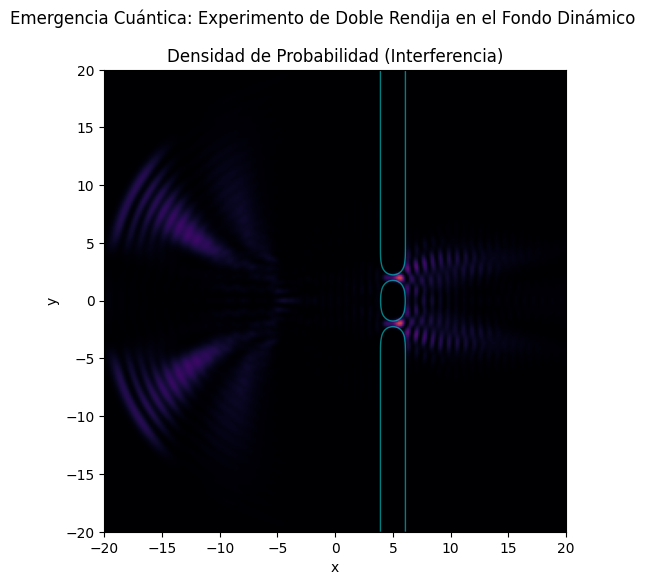

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


# ==========================================
# 1. CONFIGURACIÓN DEL EXPERIMENTO
# ==========================================

N = 256             # Resolución
L = 40.0            # Tamaño de la caja
dt = 0.01           # Paso de tiempo
g = 2.0             # No linealidad (interacción del fondo)

x = np.linspace(-L/2, L/2, N)
y = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]

# Espacio k
k = 2 * np.pi * np.fft.fftfreq(N, d=dx)
KX, KY = np.meshgrid(k, k)
K2 = KX**2 + KY**2

# ==========================================
# 2. LA BARRERA DE DOBLE RENDIJA
# ==========================================

# Muro vertical en x = 5
Wall_Pos = 5.0
Wall_Thickness = 1.0
Slit_Separation = 4.0
Slit_Width = 1.5

# Construimos el potencial V(x,y)
# Empezamos con un muro infinito
V_wall = 100.0 * np.exp(-((X - Wall_Pos)**2) / (2 * (Wall_Thickness/2)**2))

# "Taladramos" las rendijas (multiplicamos por funciones ventana inversas)
# Rendija 1 (Arriba)
Slit1 = np.exp(-((Y - Slit_Separation/2)**2) / (2 * (Slit_Width/2)**2))
# Rendija 2 (Abajo)
Slit2 = np.exp(-((Y + Slit_Separation/2)**2) / (2 * (Slit_Width/2)**2))

# El potencial final es el muro menos los agujeros (aproximadamente)
# Usamos una lógica suave: V_eff = V_wall * (1 - Slit1 - Slit2)
# Clampeamos para que no sea negativo
V_double_slit = V_wall * (1.0 - 0.95*Slit1 - 0.95*Slit2)
V_double_slit[V_double_slit < 0] = 0

# Absorción en los bordes de la caja para evitar rebotes
R = np.sqrt(X**2 + Y**2)
V_absorb = 0.5 * (R / (0.45*L))**20
V_total = V_double_slit + V_absorb

# ==========================================
# 3. LA "PARTÍCULA" (PAQUETE DE ONDAS)
# ==========================================

# Disparamos desde la izquierda (x = -10) hacia la derecha
x0 = -10.0
y0 = 0.0
k_x = 4.0  # Momento hacia la derecha
width = 2.0

Psi_0 = np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * width**2)) * np.exp(1j * k_x * X)
# Normalizamos
Psi_0 /= np.sqrt(np.sum(np.abs(Psi_0)**2) * dx * dx)

Psi = Psi_0.copy()

# ==========================================
# 4. SIMULACIÓN Y VISUALIZACIÓN
# ==========================================

# Operador Cinético
U_kin = np.exp(-1j * (K2/2) * dt)

def step(psi_in):
    # Split-Step Fourier
    # 1. Potencial (Lineal + No Lineal)
    rho = np.abs(psi_in)**2
    psi_mod = psi_in * np.exp(-1j * (V_total + g*rho) * (dt/2))
    
    # 2. Cinética
    psi_k = np.fft.fft2(psi_mod)
    psi_k *= U_kin
    psi_mod = np.fft.ifft2(psi_k)
    
    # 3. Potencial
    rho = np.abs(psi_mod)**2
    psi_out = psi_mod * np.exp(-1j * (V_total + g*rho) * (dt/2))
    
    return psi_out

# Gráficos
fig, ax = plt.subplots(figsize=(10, 6))
plt.suptitle("Emergencia Cuántica: Experimento de Doble Rendija en el Fondo Dinámico")

# Mostramos la densidad |Psi|^2
# Usamos una escala logarítmica o de potencia para ver mejor las franjas débiles
im = ax.imshow(np.abs(Psi)**2, extent=[-L/2, L/2, -L/2, L/2], 
               cmap='inferno', origin='lower', vmin=0, vmax=0.05)

# Dibujamos el contorno de las rendijas para referencia visual
ax.contour(X, Y, V_double_slit, levels=[10.0], colors='cyan', linewidths=1, alpha=0.5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Densidad de Probabilidad (Interferencia)")

def update(frame):
    global Psi
    # Evolucionamos rápido
    for _ in range(6):
        Psi = step(Psi)
    
    im.set_data(np.abs(Psi)**2)
    return im,

# Animación larga para ver el cruce
ani = animation.FuncAnimation(fig, update, frames=200, interval=20, blit=True)
display(HTML(ani.to_html5_video()))